$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Deep \space Learning $$
$$ Lab \space no. \space 4 $$

## `+` Import Libraries

In [ ]:
import gdown

# `+` Seed Value

In [ ]:
SEED = 907

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [ ]:
#gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

In [ ]:
#%%capture
#!unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [1]:
import tensorflow

In [2]:
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Lambda
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten , Conv2DTranspose , Concatenate
from keras.models import Sequential, Model
from keras.layers import BatchNormalization ,Dropout
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from PIL import Image


In [3]:
print("TensorFlow Version:", tf.__version__)

# Check if GPU is available
print("GPU Available:", tf.test.is_gpu_available())

# List available GPUs
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'/kaggle/input/lung-data/Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [ ]:
grey_train, grey_val = image_dataset_from_directory('Lung_Data_PNG/grey',
batch_size=8,
seed=123,
image_size=(512, 512),
color_mode="grayscale",
labels=None,
validation_split=0.15,
subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


I0000 00:00:1744582946.834752      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [ ]:
mask_train, mask_val = image_dataset_from_directory('Lung_Data_PNG/mask',
batch_size=8,
seed=123,
image_size=(512, 512),
color_mode="grayscale",
labels=None,
validation_split=0.15,
subset="both")

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


### Preview the Images

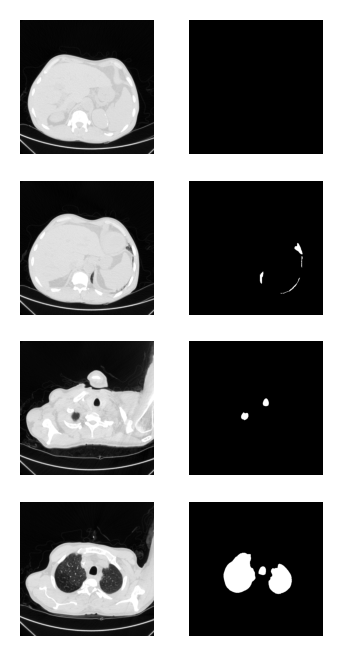

In [ ]:
# Preview Images
plt.figure(figsize=(2, 4) , dpi=200)
for image , mask in zip(grey_train.take(3) , mask_train.take(3)):
    for i in range(4):
        ax = plt.subplot(4, 2, i*2 + 1)
        plt.imshow(image[i]  , cmap='gray')
        plt.axis("off")
        ax = plt.subplot(4, 2, i*2+ 2)
        plt.imshow(mask[i] , cmap='gray')
        plt.axis("off")


## `+` Set Global Parameters

In [ ]:
# Hyperparameters
BATCH_SIZE  = 8
EPOCHS      = 15

## `i` Model Design

In [ ]:
def conv_layer(input, num_layers , num_filters ):
  for _ in range(num_layers):
    input = Conv2D(num_filters , (3,3), padding='same' , kernel_initializer= 'he_normal',  activation='relu')(input)
    input = BatchNormalization()(input)

  return input

In [ ]:
def down_sambling(input , num_filters ):
  first_layers = conv_layer(input , 2 , num_filters )
  second_layers = MaxPool2D()(first_layers)
  return first_layers , second_layers

In [ ]:
def up_sampling(input  , n_filters  , skip_features):
  input = Conv2DTranspose(n_filters, (3, 3), strides = 2, padding='same')(input)  # Step 1: Upsample
  input = Concatenate()([input, skip_features])                                  # Step 2: Skip connection
  input = conv_layer(input , 2 , n_filters)                          # Step 3: Feature refinement
  return  input

####U_net

In [ ]:
inputs = Input((512, 512, 1))

scaled_input = Rescaling(scale=1./255)(inputs)

#down samble
l1,l2 = down_sambling(scaled_input , 16 )
l3,l4 = down_sambling(l2 , 32 )
l5,l6 = down_sambling(l4 , 64 )

#bottelneck
bottleneck = conv_layer(l6 , 2 , 128)

#up sampling
up1 = up_sampling(bottleneck , 64  , l5)
up2 = up_sampling(up1 , 32 , l3)
up3 = up_sampling(up2 , 16 , l1)

#mask
output = Conv2D(1 , (1,1) , padding='same' , activation='sigmoid')(up3)

model = Model(inputs , output , name='Mariam_Unet')
model.summary()



Model: "Mariam_Unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 512, 512, 1)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 16)   │            160 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 16)   │          2,320 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 128, 128, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 128, 128, 64)   │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization) 

 Total params: 538,321 (2.05 MB)

 Trainable params: 536,913 (2.05 MB)

 Non-trainable params: 1,408 (5.50 KB)

## `ii` Model Compilation & Training

####rescaling

In [ ]:
data_train = tf.data.Dataset.zip(grey_train, mask_train.map(lambda x: Rescaling(1./255)(x)))
data_val = tf.data.Dataset.zip(grey_val, mask_val.map(lambda x: Rescaling(1./255)(x)))

In [ ]:
import keras

In [ ]:
model.compile(keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

## `iii` Model Evaluation

In [ ]:
history = model.fit(data_train, epochs=30, validation_data= data_val)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.9933 - loss: 0.0219 - val_accuracy: 0.9933 - val_loss: 0.0334
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9945 - loss: 0.0175 - val_accuracy: 0.9863 - val_loss: 0.0634
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9944 - loss: 0.0167 - val_accuracy: 0.9917 - val_loss: 0.0297
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9948 - loss: 0.0166 - val_accuracy: 0.9944 - val_loss: 0.0204
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9945 - loss: 0.0158 - val_accuracy: 0.9953 - val_loss: 0.0146
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9949 - loss: 0.0152 - val_accuracy: 0.9960 - val_loss: 0.0106
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9955 - loss: 0.0134 - val_accuracy: 0.9951 - val_loss: 0.0161
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9960 - loss: 0.0116 - val_accuracy: 0

## `iv` Result Visualization

In [ ]:
model.evaluate(data_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9973 - loss: 0.0069


[0.008542738854885101, 0.9965900182723999]

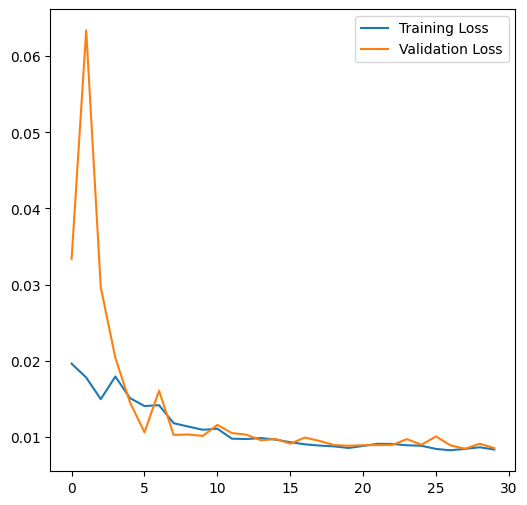

In [ ]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

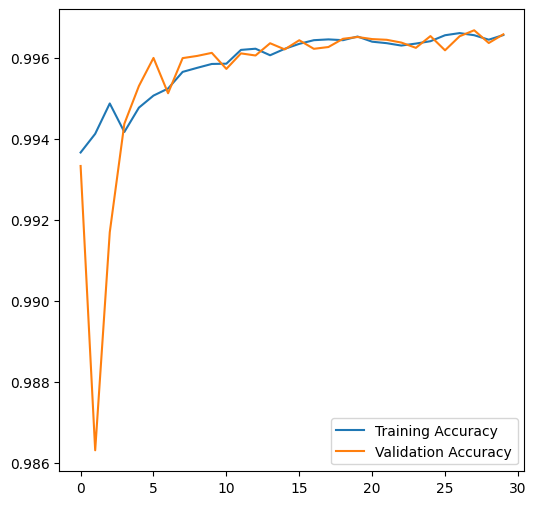

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

In [ ]:
preds = model.predict(list(grey_val.take(1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


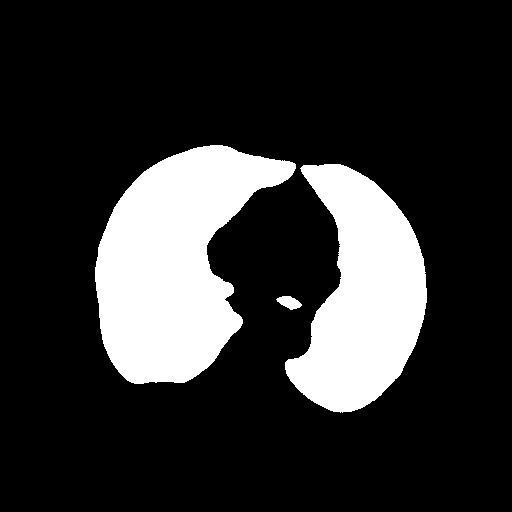

In [ ]:
keras.utils.array_to_img(preds[5] > 0.2)

**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

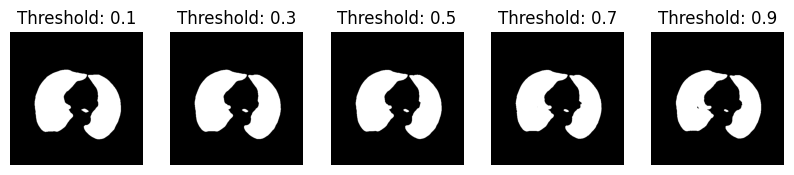

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

for i, threshold in enumerate(thresholds):
    plt.subplot(5, 5, i + 1)

    predicted_mask = preds[5] > threshold
    plt.imshow(predicted_mask, cmap='gray')
    plt.title(f'Threshold: {threshold}')
    plt.axis('off')
plt.show()